In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/2934 [00:01<52:14,  1.07s/it]

  0%|▎                                                                                                                                                  | 6/2934 [00:01<07:24,  6.59it/s]

  0%|▌                                                                                                                                                 | 11/2934 [00:01<03:53, 12.52it/s]

  1%|▊                                                                                                                                                 | 16/2934 [00:01<02:39, 18.34it/s]

  1%|█                                                                                                                                                 | 21/2934 [00:01<02:02, 23.69it/s]

  1%|█▎                                                                                                                                                | 26/2934 [00:01<01:42, 28.39it/s]

  1%|█▌                                                                                                                                                | 31/2934 [00:01<01:29, 32.33it/s]

  1%|█▊                                                                                                                                                | 36/2934 [00:01<01:21, 35.47it/s]

  1%|██                                                                                                                                                | 41/2934 [00:01<01:16, 37.90it/s]

  2%|██▎                                                                                                                                               | 46/2934 [00:02<01:12, 39.77it/s]

  2%|██▌                                                                                                                                               | 51/2934 [00:02<01:10, 41.09it/s]

  2%|██▊                                                                                                                                               | 56/2934 [00:02<01:08, 42.06it/s]

  2%|███                                                                                                                                               | 61/2934 [00:02<01:07, 42.82it/s]

  2%|███▎                                                                                                                                              | 66/2934 [00:02<01:06, 43.30it/s]

  2%|███▌                                                                                                                                              | 71/2934 [00:02<01:05, 43.63it/s]

  3%|███▊                                                                                                                                              | 76/2934 [00:02<01:05, 43.86it/s]

  3%|████                                                                                                                                              | 81/2934 [00:02<01:04, 44.10it/s]

  3%|████▎                                                                                                                                             | 86/2934 [00:02<01:04, 44.19it/s]

  3%|████▌                                                                                                                                             | 91/2934 [00:03<01:04, 44.26it/s]

  3%|████▊                                                                                                                                             | 96/2934 [00:03<01:03, 44.37it/s]

  3%|████▉                                                                                                                                            | 101/2934 [00:03<01:03, 44.38it/s]

  4%|█████▏                                                                                                                                           | 106/2934 [00:03<01:03, 44.41it/s]

  4%|█████▍                                                                                                                                           | 111/2934 [00:03<01:03, 44.43it/s]

  4%|█████▋                                                                                                                                           | 116/2934 [00:03<01:03, 44.48it/s]

  4%|█████▉                                                                                                                                           | 121/2934 [00:03<01:03, 44.39it/s]

  4%|██████▏                                                                                                                                          | 126/2934 [00:03<01:03, 44.39it/s]

  4%|██████▍                                                                                                                                          | 131/2934 [00:03<01:03, 44.46it/s]

  5%|██████▋                                                                                                                                          | 136/2934 [00:04<01:02, 44.45it/s]

  5%|██████▉                                                                                                                                          | 141/2934 [00:04<01:02, 44.44it/s]

  5%|███████▏                                                                                                                                         | 146/2934 [00:04<01:02, 44.44it/s]

  5%|███████▍                                                                                                                                         | 151/2934 [00:04<01:02, 44.48it/s]

  5%|███████▋                                                                                                                                         | 156/2934 [00:04<01:02, 44.44it/s]

  5%|███████▉                                                                                                                                         | 161/2934 [00:04<01:02, 44.45it/s]

  6%|████████▏                                                                                                                                        | 166/2934 [00:04<01:02, 44.52it/s]

  6%|████████▍                                                                                                                                        | 171/2934 [00:04<01:02, 44.48it/s]

  6%|████████▋                                                                                                                                        | 176/2934 [00:05<01:02, 44.44it/s]

  6%|████████▉                                                                                                                                        | 181/2934 [00:05<01:02, 44.40it/s]

  6%|█████████▏                                                                                                                                       | 186/2934 [00:05<01:01, 44.48it/s]

  7%|█████████▍                                                                                                                                       | 191/2934 [00:05<01:01, 44.48it/s]

  7%|█████████▋                                                                                                                                       | 196/2934 [00:05<01:01, 44.40it/s]

  7%|█████████▉                                                                                                                                       | 201/2934 [00:05<01:01, 44.48it/s]

  7%|██████████▏                                                                                                                                      | 206/2934 [00:05<01:01, 44.46it/s]

  7%|██████████▍                                                                                                                                      | 211/2934 [00:05<01:01, 44.46it/s]

  7%|██████████▋                                                                                                                                      | 216/2934 [00:05<01:01, 44.45it/s]

  8%|██████████▉                                                                                                                                      | 221/2934 [00:06<01:01, 44.47it/s]

  8%|███████████▏                                                                                                                                     | 226/2934 [00:06<01:00, 44.50it/s]

  8%|███████████▍                                                                                                                                     | 231/2934 [00:06<01:00, 44.50it/s]

  8%|███████████▋                                                                                                                                     | 236/2934 [00:06<01:00, 44.49it/s]

  8%|███████████▉                                                                                                                                     | 241/2934 [00:06<01:00, 44.56it/s]

  8%|████████████▏                                                                                                                                    | 246/2934 [00:06<01:00, 44.52it/s]

  9%|████████████▍                                                                                                                                    | 251/2934 [00:06<01:00, 44.47it/s]

  9%|████████████▋                                                                                                                                    | 256/2934 [00:06<01:00, 44.46it/s]

  9%|████████████▉                                                                                                                                    | 261/2934 [00:06<01:00, 44.45it/s]

  9%|█████████████▏                                                                                                                                   | 266/2934 [00:07<00:59, 44.50it/s]

  9%|█████████████▍                                                                                                                                   | 271/2934 [00:07<00:59, 44.48it/s]

  9%|█████████████▋                                                                                                                                   | 276/2934 [00:07<00:59, 44.45it/s]

 10%|█████████████▉                                                                                                                                   | 281/2934 [00:07<00:59, 44.45it/s]

 10%|██████████████▏                                                                                                                                  | 286/2934 [00:07<00:59, 44.53it/s]

 10%|██████████████▍                                                                                                                                  | 291/2934 [00:07<00:59, 44.52it/s]

 10%|██████████████▋                                                                                                                                  | 296/2934 [00:07<00:59, 44.49it/s]

 10%|██████████████▉                                                                                                                                  | 301/2934 [00:07<00:59, 44.49it/s]

 10%|███████████████                                                                                                                                  | 306/2934 [00:07<00:58, 44.55it/s]

 11%|███████████████▎                                                                                                                                 | 311/2934 [00:08<00:58, 44.46it/s]

 11%|███████████████▌                                                                                                                                 | 316/2934 [00:08<00:58, 44.42it/s]

 11%|███████████████▊                                                                                                                                 | 321/2934 [00:08<00:58, 44.40it/s]

 11%|████████████████                                                                                                                                 | 326/2934 [00:08<00:58, 44.45it/s]

 11%|████████████████▎                                                                                                                                | 331/2934 [00:08<00:58, 44.46it/s]

 11%|████████████████▌                                                                                                                                | 336/2934 [00:08<00:58, 44.45it/s]

 12%|████████████████▊                                                                                                                                | 341/2934 [00:08<00:58, 44.51it/s]

 12%|█████████████████                                                                                                                                | 346/2934 [00:08<00:58, 44.48it/s]

 12%|█████████████████▎                                                                                                                               | 351/2934 [00:08<00:58, 44.48it/s]

 12%|█████████████████▌                                                                                                                               | 356/2934 [00:09<00:57, 44.47it/s]

 12%|█████████████████▊                                                                                                                               | 361/2934 [00:09<00:57, 44.51it/s]

 12%|██████████████████                                                                                                                               | 366/2934 [00:09<00:57, 44.47it/s]

 13%|██████████████████▎                                                                                                                              | 371/2934 [00:09<00:57, 44.45it/s]

 13%|██████████████████▌                                                                                                                              | 376/2934 [00:09<00:57, 44.46it/s]

 13%|██████████████████▊                                                                                                                              | 381/2934 [00:09<00:57, 44.50it/s]

 13%|███████████████████                                                                                                                              | 386/2934 [00:09<00:57, 44.50it/s]

 13%|███████████████████▎                                                                                                                             | 391/2934 [00:09<00:57, 44.48it/s]

 13%|███████████████████▌                                                                                                                             | 396/2934 [00:09<00:56, 44.55it/s]

 14%|███████████████████▊                                                                                                                             | 401/2934 [00:10<00:56, 44.48it/s]

 14%|████████████████████                                                                                                                             | 406/2934 [00:10<00:56, 44.43it/s]

 14%|████████████████████▎                                                                                                                            | 411/2934 [00:10<00:56, 44.43it/s]

 14%|████████████████████▌                                                                                                                            | 416/2934 [00:10<00:56, 44.49it/s]

 14%|████████████████████▊                                                                                                                            | 421/2934 [00:10<00:56, 44.49it/s]

 15%|█████████████████████                                                                                                                            | 426/2934 [00:10<00:56, 44.47it/s]

 15%|█████████████████████▎                                                                                                                           | 431/2934 [00:10<00:56, 44.47it/s]

 15%|█████████████████████▌                                                                                                                           | 436/2934 [00:10<00:56, 44.52it/s]

 15%|█████████████████████▊                                                                                                                           | 441/2934 [00:10<00:56, 44.50it/s]

 15%|██████████████████████                                                                                                                           | 446/2934 [00:11<00:55, 44.48it/s]

 15%|██████████████████████▎                                                                                                                          | 451/2934 [00:11<00:55, 44.52it/s]

 16%|██████████████████████▌                                                                                                                          | 456/2934 [00:11<00:55, 44.41it/s]

 16%|██████████████████████▊                                                                                                                          | 461/2934 [00:11<00:55, 44.49it/s]

 16%|███████████████████████                                                                                                                          | 466/2934 [00:11<00:55, 44.52it/s]

 16%|███████████████████████▎                                                                                                                         | 471/2934 [00:11<00:55, 44.57it/s]

 16%|███████████████████████▌                                                                                                                         | 476/2934 [00:11<00:55, 44.46it/s]

 16%|███████████████████████▊                                                                                                                         | 481/2934 [00:11<00:55, 44.43it/s]

 17%|████████████████████████                                                                                                                         | 486/2934 [00:11<00:55, 44.44it/s]

 17%|████████████████████████▎                                                                                                                        | 491/2934 [00:12<00:54, 44.49it/s]

 17%|████████████████████████▌                                                                                                                        | 496/2934 [00:12<00:54, 44.48it/s]

 17%|████████████████████████▊                                                                                                                        | 501/2934 [00:12<00:54, 44.49it/s]

 17%|█████████████████████████                                                                                                                        | 506/2934 [00:12<00:54, 44.52it/s]

 17%|█████████████████████████▎                                                                                                                       | 511/2934 [00:12<00:54, 44.41it/s]

 18%|█████████████████████████▌                                                                                                                       | 516/2934 [00:12<00:54, 44.51it/s]

 18%|█████████████████████████▋                                                                                                                       | 521/2934 [00:12<00:54, 44.47it/s]

 18%|█████████████████████████▉                                                                                                                       | 526/2934 [00:12<00:54, 44.45it/s]

 18%|██████████████████████████▏                                                                                                                      | 531/2934 [00:12<00:53, 44.54it/s]

 18%|██████████████████████████▍                                                                                                                      | 536/2934 [00:13<00:53, 44.49it/s]

 18%|██████████████████████████▋                                                                                                                      | 541/2934 [00:13<00:53, 44.48it/s]

 19%|██████████████████████████▉                                                                                                                      | 546/2934 [00:13<00:53, 44.49it/s]

 19%|███████████████████████████▏                                                                                                                     | 551/2934 [00:13<00:53, 44.50it/s]

 19%|███████████████████████████▍                                                                                                                     | 556/2934 [00:13<00:53, 44.51it/s]

 19%|███████████████████████████▋                                                                                                                     | 561/2934 [00:13<00:53, 44.47it/s]

 19%|███████████████████████████▉                                                                                                                     | 566/2934 [00:13<00:53, 44.49it/s]

 19%|████████████████████████████▏                                                                                                                    | 571/2934 [00:13<00:53, 44.48it/s]

 20%|████████████████████████████▍                                                                                                                    | 576/2934 [00:14<00:53, 44.33it/s]

 20%|████████████████████████████▋                                                                                                                    | 581/2934 [00:14<00:52, 44.42it/s]

 20%|████████████████████████████▉                                                                                                                    | 586/2934 [00:14<00:52, 44.43it/s]

 20%|█████████████████████████████▏                                                                                                                   | 591/2934 [00:14<00:52, 44.48it/s]

 20%|█████████████████████████████▍                                                                                                                   | 596/2934 [00:14<00:52, 44.48it/s]

 20%|█████████████████████████████▋                                                                                                                   | 601/2934 [00:14<00:52, 44.48it/s]

 21%|█████████████████████████████▉                                                                                                                   | 606/2934 [00:14<00:52, 44.52it/s]

 21%|██████████████████████████████▏                                                                                                                  | 611/2934 [00:14<00:52, 44.51it/s]

 21%|██████████████████████████████▍                                                                                                                  | 616/2934 [00:14<00:52, 44.49it/s]

 21%|██████████████████████████████▋                                                                                                                  | 621/2934 [00:15<00:52, 44.45it/s]

 21%|██████████████████████████████▉                                                                                                                  | 626/2934 [00:15<00:51, 44.44it/s]

 22%|███████████████████████████████▏                                                                                                                 | 631/2934 [00:15<00:51, 44.46it/s]

 22%|███████████████████████████████▍                                                                                                                 | 636/2934 [00:15<00:51, 44.45it/s]

 22%|███████████████████████████████▋                                                                                                                 | 641/2934 [00:15<00:51, 44.49it/s]

 22%|███████████████████████████████▉                                                                                                                 | 646/2934 [00:15<00:51, 44.44it/s]

 22%|████████████████████████████████▏                                                                                                                | 651/2934 [00:15<00:51, 44.45it/s]

 22%|████████████████████████████████▍                                                                                                                | 656/2934 [00:15<00:51, 44.46it/s]

 23%|████████████████████████████████▋                                                                                                                | 661/2934 [00:15<00:51, 44.48it/s]

 23%|████████████████████████████████▉                                                                                                                | 666/2934 [00:16<00:50, 44.48it/s]

 23%|█████████████████████████████████▏                                                                                                               | 671/2934 [00:16<00:50, 44.47it/s]

 23%|█████████████████████████████████▍                                                                                                               | 676/2934 [00:16<00:50, 44.48it/s]

 23%|█████████████████████████████████▋                                                                                                               | 681/2934 [00:16<00:50, 44.52it/s]

 23%|█████████████████████████████████▉                                                                                                               | 686/2934 [00:16<00:50, 44.49it/s]

 24%|██████████████████████████████████▏                                                                                                              | 691/2934 [00:16<00:50, 44.50it/s]

 24%|██████████████████████████████████▍                                                                                                              | 696/2934 [00:16<00:50, 44.56it/s]

 24%|██████████████████████████████████▋                                                                                                              | 701/2934 [00:16<00:50, 44.50it/s]

 24%|██████████████████████████████████▉                                                                                                              | 706/2934 [00:16<00:50, 44.47it/s]

 24%|███████████████████████████████████▏                                                                                                             | 711/2934 [00:17<00:50, 44.46it/s]

 24%|███████████████████████████████████▍                                                                                                             | 716/2934 [00:17<00:49, 44.52it/s]

 25%|███████████████████████████████████▋                                                                                                             | 721/2934 [00:17<00:49, 44.49it/s]

 25%|███████████████████████████████████▉                                                                                                             | 726/2934 [00:17<00:49, 44.45it/s]

 25%|████████████████████████████████████▏                                                                                                            | 731/2934 [00:17<00:49, 44.90it/s]

 25%|████████████████████████████████████▎                                                                                                            | 736/2934 [00:17<00:48, 45.54it/s]

 25%|████████████████████████████████████▌                                                                                                            | 741/2934 [00:17<00:47, 46.00it/s]

 25%|████████████████████████████████████▊                                                                                                            | 746/2934 [00:17<00:47, 46.31it/s]

 26%|█████████████████████████████████████                                                                                                            | 751/2934 [00:17<00:46, 46.56it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 756/2934 [00:18<00:46, 46.71it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 761/2934 [00:18<00:46, 46.83it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 766/2934 [00:18<00:46, 46.89it/s]

 26%|██████████████████████████████████████                                                                                                           | 771/2934 [00:18<00:46, 46.95it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 776/2934 [00:18<00:45, 47.00it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 781/2934 [00:18<00:45, 47.02it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 786/2934 [00:18<00:45, 47.06it/s]

 27%|███████████████████████████████████████                                                                                                          | 791/2934 [00:18<00:45, 47.04it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 796/2934 [00:18<00:45, 47.02it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 801/2934 [00:18<00:45, 47.02it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 806/2934 [00:19<00:45, 47.04it/s]

 28%|████████████████████████████████████████                                                                                                         | 811/2934 [00:19<00:45, 47.04it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 816/2934 [00:19<00:45, 47.04it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 821/2934 [00:19<00:45, 46.47it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 826/2934 [00:19<00:45, 45.87it/s]

 28%|█████████████████████████████████████████                                                                                                        | 831/2934 [00:19<00:46, 45.40it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 836/2934 [00:19<00:46, 45.18it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 841/2934 [00:19<00:46, 44.96it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 846/2934 [00:19<00:46, 44.77it/s]

 29%|██████████████████████████████████████████                                                                                                       | 851/2934 [00:20<00:46, 44.63it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 856/2934 [00:20<00:46, 44.59it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 861/2934 [00:20<00:46, 44.52it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 866/2934 [00:20<00:46, 44.52it/s]

 30%|███████████████████████████████████████████                                                                                                      | 871/2934 [00:20<00:46, 44.53it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 876/2934 [00:20<00:46, 44.49it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 881/2934 [00:20<00:46, 44.46it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 886/2934 [00:20<00:46, 44.47it/s]

 30%|████████████████████████████████████████████                                                                                                     | 891/2934 [00:20<00:45, 44.54it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 896/2934 [00:21<00:45, 44.49it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 901/2934 [00:21<00:45, 44.44it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 906/2934 [00:21<00:45, 44.48it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 911/2934 [00:21<00:45, 44.46it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 916/2934 [00:21<00:45, 44.44it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 921/2934 [00:21<00:45, 44.33it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 926/2934 [00:21<00:45, 44.21it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 931/2934 [00:21<00:45, 44.05it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 936/2934 [00:21<00:45, 43.94it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 941/2934 [00:22<00:45, 43.87it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 946/2934 [00:22<00:45, 43.80it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 951/2934 [00:22<00:45, 43.75it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 956/2934 [00:22<00:45, 43.69it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 961/2934 [00:22<00:45, 43.69it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 966/2934 [00:22<00:45, 43.69it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 971/2934 [00:22<00:44, 43.67it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 976/2934 [00:22<00:44, 43.66it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 981/2934 [00:23<00:44, 43.66it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 986/2934 [00:23<00:44, 43.64it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 991/2934 [00:23<00:44, 43.65it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 996/2934 [00:23<00:44, 43.65it/s]

 34%|█████████████████████████████████████████████████▏                                                                                              | 1001/2934 [00:23<00:44, 43.66it/s]

 34%|█████████████████████████████████████████████████▎                                                                                              | 1006/2934 [00:23<00:44, 43.66it/s]

 34%|█████████████████████████████████████████████████▌                                                                                              | 1011/2934 [00:23<00:44, 43.64it/s]

 35%|█████████████████████████████████████████████████▊                                                                                              | 1016/2934 [00:23<00:43, 43.64it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 1021/2934 [00:23<00:43, 43.66it/s]

 35%|██████████████████████████████████████████████████▎                                                                                             | 1026/2934 [00:24<00:43, 43.67it/s]

 35%|██████████████████████████████████████████████████▌                                                                                             | 1031/2934 [00:24<00:43, 43.67it/s]

 35%|██████████████████████████████████████████████████▊                                                                                             | 1036/2934 [00:24<00:43, 43.62it/s]

 35%|███████████████████████████████████████████████████                                                                                             | 1041/2934 [00:24<00:43, 43.73it/s]

 36%|███████████████████████████████████████████████████▎                                                                                            | 1046/2934 [00:24<00:43, 43.72it/s]

 36%|███████████████████████████████████████████████████▌                                                                                            | 1051/2934 [00:24<00:43, 43.71it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 1056/2934 [00:24<00:42, 43.71it/s]

 36%|████████████████████████████████████████████████████                                                                                            | 1061/2934 [00:24<00:42, 43.70it/s]

 36%|████████████████████████████████████████████████████▎                                                                                           | 1066/2934 [00:24<00:42, 43.68it/s]

 37%|████████████████████████████████████████████████████▌                                                                                           | 1071/2934 [00:25<00:42, 43.69it/s]

 37%|████████████████████████████████████████████████████▊                                                                                           | 1076/2934 [00:25<00:42, 43.68it/s]

 37%|█████████████████████████████████████████████████████                                                                                           | 1081/2934 [00:25<00:42, 43.68it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 1086/2934 [00:25<00:42, 43.69it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                          | 1091/2934 [00:25<00:42, 43.70it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                          | 1096/2934 [00:25<00:42, 43.69it/s]

 38%|██████████████████████████████████████████████████████                                                                                          | 1101/2934 [00:25<00:41, 43.68it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                         | 1106/2934 [00:25<00:41, 43.65it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                         | 1111/2934 [00:26<00:41, 43.67it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                         | 1116/2934 [00:26<00:41, 43.69it/s]

 38%|███████████████████████████████████████████████████████                                                                                         | 1121/2934 [00:26<00:41, 43.70it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1126/2934 [00:26<00:41, 43.70it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                        | 1131/2934 [00:26<00:41, 43.69it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                        | 1136/2934 [00:26<00:41, 43.67it/s]

 39%|████████████████████████████████████████████████████████                                                                                        | 1141/2934 [00:26<00:41, 43.67it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1146/2934 [00:26<00:40, 43.68it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1151/2934 [00:26<00:40, 43.69it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1156/2934 [00:27<00:40, 43.70it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 1161/2934 [00:27<00:40, 43.69it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 1166/2934 [00:27<00:40, 43.68it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                      | 1171/2934 [00:27<00:40, 43.57it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                      | 1176/2934 [00:27<00:40, 43.61it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                      | 1181/2934 [00:27<00:40, 43.63it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 1186/2934 [00:27<00:40, 43.63it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 1191/2934 [00:27<00:39, 43.64it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1196/2934 [00:27<00:39, 43.66it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1201/2934 [00:28<00:39, 43.66it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1206/2934 [00:28<00:39, 43.65it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 1211/2934 [00:28<00:39, 43.65it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 1216/2934 [00:28<00:39, 43.68it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 1221/2934 [00:28<00:39, 43.69it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 1226/2934 [00:28<00:39, 43.69it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 1231/2934 [00:28<00:38, 43.69it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                   | 1236/2934 [00:28<00:38, 43.67it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1241/2934 [00:28<00:38, 43.67it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                  | 1246/2934 [00:29<00:38, 43.69it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1251/2934 [00:29<00:38, 43.69it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1256/2934 [00:29<00:38, 43.68it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1261/2934 [00:29<00:38, 43.68it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 1266/2934 [00:29<00:38, 43.66it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1271/2934 [00:29<00:38, 43.67it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                 | 1276/2934 [00:29<00:37, 43.69it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1281/2934 [00:29<00:37, 43.69it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1286/2934 [00:30<00:37, 43.69it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1291/2934 [00:30<00:37, 43.66it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 1296/2934 [00:30<00:37, 43.67it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1301/2934 [00:30<00:37, 43.66it/s]

 45%|████████████████████████████████████████████████████████████████                                                                                | 1306/2934 [00:30<00:37, 43.68it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                               | 1311/2934 [00:30<00:37, 43.67it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                               | 1316/2934 [00:30<00:37, 43.57it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1321/2934 [00:30<00:36, 43.61it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 1326/2934 [00:30<00:36, 43.64it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1331/2934 [00:31<00:36, 43.65it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1336/2934 [00:31<00:36, 43.65it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1341/2934 [00:31<00:36, 43.64it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 1346/2934 [00:31<00:36, 43.65it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                             | 1351/2934 [00:31<00:36, 43.67it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                             | 1356/2934 [00:31<00:36, 43.67it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                             | 1361/2934 [00:31<00:36, 43.68it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 1366/2934 [00:31<00:35, 43.69it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                            | 1371/2934 [00:31<00:35, 43.68it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 1376/2934 [00:32<00:35, 43.66it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 1381/2934 [00:32<00:35, 43.68it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1386/2934 [00:32<00:35, 43.70it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1391/2934 [00:32<00:35, 43.70it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                           | 1396/2934 [00:32<00:35, 43.70it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 1401/2934 [00:32<00:35, 43.68it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1406/2934 [00:32<00:34, 43.67it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 1411/2934 [00:32<00:34, 43.66it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1416/2934 [00:32<00:34, 43.68it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1421/2934 [00:33<00:34, 43.69it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 1426/2934 [00:33<00:34, 43.68it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 1431/2934 [00:33<00:34, 43.67it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 1436/2934 [00:33<00:34, 43.68it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 1441/2934 [00:33<00:34, 43.68it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                         | 1446/2934 [00:33<00:34, 43.67it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 1451/2934 [00:33<00:33, 43.67it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 1456/2934 [00:33<00:33, 43.68it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 1461/2934 [00:34<00:33, 43.65it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 1466/2934 [00:34<00:33, 43.66it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1471/2934 [00:34<00:33, 43.66it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1476/2934 [00:34<00:33, 43.66it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                       | 1481/2934 [00:34<00:33, 43.52it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1486/2934 [00:34<00:33, 43.58it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 1491/2934 [00:34<00:33, 43.59it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 1496/2934 [00:34<00:32, 43.61it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                      | 1501/2934 [00:34<00:32, 43.65it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1506/2934 [00:35<00:32, 43.65it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 1511/2934 [00:35<00:32, 43.65it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1516/2934 [00:35<00:32, 43.66it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1521/2934 [00:35<00:32, 43.67it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1526/2934 [00:35<00:32, 43.68it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1531/2934 [00:35<00:32, 43.68it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 1536/2934 [00:35<00:32, 43.68it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 1541/2934 [00:35<00:31, 43.70it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1546/2934 [00:35<00:31, 43.69it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1551/2934 [00:36<00:31, 43.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1556/2934 [00:36<00:31, 43.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 1561/2934 [00:36<00:31, 43.70it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1566/2934 [00:36<00:31, 43.69it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1571/2934 [00:36<00:31, 43.68it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1576/2934 [00:36<00:31, 43.69it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1581/2934 [00:36<00:30, 43.68it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1586/2934 [00:36<00:30, 43.67it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1591/2934 [00:36<00:30, 43.68it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1596/2934 [00:37<00:30, 43.67it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1601/2934 [00:37<00:30, 43.66it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1606/2934 [00:37<00:30, 43.66it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1611/2934 [00:37<00:30, 43.67it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1616/2934 [00:37<00:30, 43.67it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1621/2934 [00:37<00:30, 43.67it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1626/2934 [00:37<00:29, 43.69it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1631/2934 [00:37<00:29, 43.68it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 1636/2934 [00:38<00:29, 43.68it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1641/2934 [00:38<00:29, 43.68it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1646/2934 [00:38<00:29, 43.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1651/2934 [00:38<00:29, 43.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1656/2934 [00:38<00:29, 43.67it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1661/2934 [00:38<00:29, 43.69it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1666/2934 [00:38<00:29, 43.57it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1671/2934 [00:38<00:28, 43.61it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1676/2934 [00:38<00:28, 43.62it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1681/2934 [00:39<00:28, 43.64it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1686/2934 [00:39<00:28, 43.66it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1691/2934 [00:39<00:28, 43.67it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1696/2934 [00:39<00:28, 43.68it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1701/2934 [00:39<00:28, 43.67it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1706/2934 [00:39<00:28, 43.67it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1711/2934 [00:39<00:28, 43.66it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1716/2934 [00:39<00:27, 43.66it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1721/2934 [00:39<00:27, 43.67it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1726/2934 [00:40<00:27, 43.68it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1731/2934 [00:40<00:27, 43.68it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1736/2934 [00:40<00:27, 43.67it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1741/2934 [00:40<00:27, 43.65it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1746/2934 [00:40<00:27, 43.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1751/2934 [00:40<00:27, 43.66it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1756/2934 [00:40<00:26, 43.66it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1761/2934 [00:40<00:26, 43.65it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1766/2934 [00:41<00:26, 43.66it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1771/2934 [00:41<00:26, 43.64it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1776/2934 [00:41<00:26, 43.64it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1781/2934 [00:41<00:26, 43.64it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1786/2934 [00:41<00:26, 43.64it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1791/2934 [00:41<00:26, 43.64it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1796/2934 [00:41<00:26, 43.65it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1801/2934 [00:41<00:25, 43.67it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1806/2934 [00:41<00:25, 43.68it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1811/2934 [00:42<00:25, 43.66it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1816/2934 [00:42<00:25, 43.67it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1821/2934 [00:42<00:25, 43.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1826/2934 [00:42<00:25, 43.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1831/2934 [00:42<00:25, 43.69it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1836/2934 [00:42<00:25, 43.69it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1841/2934 [00:42<00:25, 43.69it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1846/2934 [00:42<00:24, 43.68it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1851/2934 [00:42<00:24, 43.68it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1856/2934 [00:43<00:24, 43.67it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1861/2934 [00:43<00:24, 43.67it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1866/2934 [00:43<00:24, 43.67it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1871/2934 [00:43<00:24, 43.24it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1876/2934 [00:43<00:24, 43.59it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1881/2934 [00:43<00:23, 43.92it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1886/2934 [00:43<00:23, 44.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1891/2934 [00:43<00:23, 44.34it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1896/2934 [00:43<00:23, 44.46it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1901/2934 [00:44<00:23, 44.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1906/2934 [00:44<00:23, 44.60it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1911/2934 [00:44<00:22, 44.55it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1916/2934 [00:44<00:22, 44.56it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1921/2934 [00:44<00:22, 44.51it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1926/2934 [00:44<00:22, 44.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1931/2934 [00:44<00:22, 44.48it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1936/2934 [00:44<00:22, 44.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1941/2934 [00:44<00:22, 44.52it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1946/2934 [00:45<00:22, 44.49it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1951/2934 [00:45<00:22, 44.51it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1956/2934 [00:45<00:21, 44.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1961/2934 [00:45<00:21, 44.45it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1966/2934 [00:45<00:21, 44.44it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1971/2934 [00:45<00:21, 44.51it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1976/2934 [00:45<00:21, 44.50it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1981/2934 [00:45<00:21, 44.50it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1986/2934 [00:45<00:21, 44.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1991/2934 [00:46<00:21, 44.49it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1996/2934 [00:46<00:21, 44.47it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2001/2934 [00:46<00:20, 44.47it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2006/2934 [00:46<00:20, 44.52it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2011/2934 [00:46<00:20, 44.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2016/2934 [00:46<00:20, 44.47it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2021/2934 [00:46<00:20, 44.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2026/2934 [00:46<00:20, 44.47it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2031/2934 [00:47<00:20, 44.45it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2036/2934 [00:47<00:20, 44.45it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2041/2934 [00:47<00:20, 44.53it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2046/2934 [00:47<00:19, 44.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2051/2934 [00:47<00:19, 44.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2056/2934 [00:47<00:19, 44.51it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2061/2934 [00:47<00:19, 44.48it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2066/2934 [00:47<00:19, 44.46it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2071/2934 [00:47<00:19, 44.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2076/2934 [00:48<00:19, 44.51it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2081/2934 [00:48<00:19, 44.48it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2086/2934 [00:48<00:19, 44.44it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2091/2934 [00:48<00:18, 44.46it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2096/2934 [00:48<00:18, 44.45it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2101/2934 [00:48<00:18, 44.40it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2106/2934 [00:48<00:18, 44.23it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2111/2934 [00:48<00:18, 44.05it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2116/2934 [00:48<00:18, 43.94it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2121/2934 [00:49<00:18, 43.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2126/2934 [00:49<00:18, 43.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2131/2934 [00:49<00:18, 43.77it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2136/2934 [00:49<00:18, 43.75it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2141/2934 [00:49<00:18, 43.71it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2146/2934 [00:49<00:18, 43.67it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2151/2934 [00:49<00:17, 43.63it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2156/2934 [00:49<00:17, 43.64it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2161/2934 [00:49<00:17, 43.65it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2166/2934 [00:50<00:17, 43.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2171/2934 [00:50<00:17, 43.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2176/2934 [00:50<00:17, 43.63it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2181/2934 [00:50<00:17, 43.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2186/2934 [00:50<00:17, 43.61it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2191/2934 [00:50<00:17, 43.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2196/2934 [00:50<00:16, 43.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2201/2934 [00:50<00:16, 43.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2206/2934 [00:50<00:16, 43.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2211/2934 [00:51<00:16, 43.62it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2216/2934 [00:51<00:16, 43.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2221/2934 [00:51<00:16, 43.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2226/2934 [00:51<00:16, 43.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2231/2934 [00:51<00:16, 43.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2236/2934 [00:51<00:15, 43.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2241/2934 [00:51<00:15, 43.63it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2246/2934 [00:51<00:15, 43.63it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2251/2934 [00:52<00:15, 43.63it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2256/2934 [00:52<00:15, 43.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2261/2934 [00:52<00:15, 43.63it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2266/2934 [00:52<00:15, 43.64it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2271/2934 [00:52<00:15, 43.62it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2276/2934 [00:52<00:15, 43.61it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2281/2934 [00:52<00:14, 43.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2286/2934 [00:52<00:14, 43.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2291/2934 [00:52<00:14, 43.61it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2296/2934 [00:53<00:14, 43.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2301/2934 [00:53<00:14, 43.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2306/2934 [00:53<00:14, 43.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2311/2934 [00:53<00:14, 43.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2316/2934 [00:53<00:14, 43.62it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2321/2934 [00:53<00:14, 43.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2326/2934 [00:53<00:13, 43.61it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2331/2934 [00:53<00:13, 43.63it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2336/2934 [00:53<00:13, 43.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2341/2934 [00:54<00:13, 43.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2346/2934 [00:54<00:13, 43.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2351/2934 [00:54<00:13, 43.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2356/2934 [00:54<00:13, 43.63it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2361/2934 [00:54<00:13, 43.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2366/2934 [00:54<00:13, 43.63it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2371/2934 [00:54<00:12, 43.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2376/2934 [00:54<00:12, 43.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2381/2934 [00:54<00:12, 43.65it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2386/2934 [00:55<00:12, 43.65it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2391/2934 [00:55<00:12, 43.64it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2396/2934 [00:55<00:12, 43.64it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2401/2934 [00:55<00:12, 43.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2406/2934 [00:55<00:12, 43.64it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2411/2934 [00:55<00:11, 43.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2416/2934 [00:55<00:11, 43.63it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2421/2934 [00:55<00:11, 43.64it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2426/2934 [00:56<00:11, 43.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2431/2934 [00:56<00:11, 43.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2436/2934 [00:56<00:11, 43.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2441/2934 [00:56<00:11, 43.61it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2446/2934 [00:56<00:11, 43.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2451/2934 [00:56<00:11, 43.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2456/2934 [00:56<00:10, 43.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2461/2934 [00:56<00:10, 43.62it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2466/2934 [00:56<00:10, 43.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2471/2934 [00:57<00:10, 43.62it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2476/2934 [00:57<00:10, 43.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2481/2934 [00:57<00:10, 43.61it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2486/2934 [00:57<00:10, 43.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2491/2934 [00:57<00:10, 43.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2496/2934 [00:57<00:10, 43.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2501/2934 [00:57<00:09, 43.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2506/2934 [00:57<00:09, 43.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2511/2934 [00:57<00:09, 43.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2516/2934 [00:58<00:09, 43.61it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2521/2934 [00:58<00:09, 43.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2526/2934 [00:58<00:09, 43.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2531/2934 [00:58<00:09, 43.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2536/2934 [00:58<00:09, 43.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2541/2934 [00:58<00:09, 43.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2546/2934 [00:58<00:08, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2551/2934 [00:58<00:08, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2556/2934 [00:59<00:08, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2561/2934 [00:59<00:08, 43.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2566/2934 [00:59<00:08, 43.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2571/2934 [00:59<00:08, 43.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2576/2934 [00:59<00:08, 43.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2581/2934 [00:59<00:08, 43.61it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2586/2934 [00:59<00:07, 43.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2591/2934 [00:59<00:07, 43.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2596/2934 [00:59<00:07, 43.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2601/2934 [01:00<00:07, 43.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2606/2934 [01:00<00:07, 43.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2611/2934 [01:00<00:07, 43.65it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2616/2934 [01:00<00:07, 43.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2621/2934 [01:00<00:07, 43.64it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2626/2934 [01:00<00:07, 43.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2631/2934 [01:00<00:06, 43.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2636/2934 [01:00<00:06, 43.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2641/2934 [01:00<00:06, 43.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2646/2934 [01:01<00:06, 43.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2651/2934 [01:01<00:06, 43.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2656/2934 [01:01<00:06, 43.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2661/2934 [01:01<00:06, 43.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2666/2934 [01:01<00:06, 43.30it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2671/2934 [01:01<00:06, 43.76it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2676/2934 [01:01<00:05, 43.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2681/2934 [01:01<00:05, 43.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2686/2934 [01:01<00:05, 43.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2691/2934 [01:02<00:05, 43.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2696/2934 [01:02<00:05, 43.66it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2701/2934 [01:02<00:05, 43.65it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2706/2934 [01:02<00:05, 43.67it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2711/2934 [01:02<00:05, 43.65it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2716/2934 [01:02<00:04, 43.65it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2721/2934 [01:02<00:04, 43.49it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2726/2934 [01:02<00:04, 43.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2731/2934 [01:03<00:04, 43.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2736/2934 [01:03<00:04, 43.60it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2741/2934 [01:03<00:04, 43.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2746/2934 [01:03<00:04, 43.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2751/2934 [01:03<00:04, 43.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2756/2934 [01:03<00:04, 43.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2761/2934 [01:03<00:03, 43.61it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2766/2934 [01:03<00:03, 43.63it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2771/2934 [01:03<00:03, 43.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2776/2934 [01:04<00:03, 43.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2781/2934 [01:04<00:03, 43.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2786/2934 [01:04<00:03, 43.63it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2791/2934 [01:04<00:03, 43.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2796/2934 [01:04<00:03, 43.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2801/2934 [01:04<00:03, 43.62it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2806/2934 [01:04<00:02, 43.65it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2811/2934 [01:04<00:02, 43.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2816/2934 [01:04<00:02, 43.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2821/2934 [01:05<00:02, 43.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2826/2934 [01:05<00:02, 43.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2831/2934 [01:05<00:02, 43.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2836/2934 [01:05<00:02, 43.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2841/2934 [01:05<00:02, 43.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2846/2934 [01:05<00:02, 43.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2851/2934 [01:05<00:01, 43.62it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2856/2934 [01:05<00:01, 43.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2861/2934 [01:05<00:01, 43.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2866/2934 [01:06<00:01, 43.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2871/2934 [01:06<00:01, 43.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2876/2934 [01:06<00:01, 43.62it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2881/2934 [01:06<00:01, 43.64it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2886/2934 [01:06<00:01, 43.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2891/2934 [01:06<00:00, 43.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2896/2934 [01:06<00:00, 43.63it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2901/2934 [01:06<00:00, 43.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2906/2934 [01:07<00:00, 43.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2911/2934 [01:07<00:00, 43.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2916/2934 [01:07<00:00, 43.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2921/2934 [01:07<00:00, 43.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2926/2934 [01:07<00:00, 41.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [01:07<00:00, 42.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:07<00:00, 43.32it/s]

train - OK


  0%|                                                                                                                                                            | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/380 [00:00<02:47,  2.27it/s]

  2%|██▎                                                                                                                                                 | 6/380 [00:00<00:27, 13.40it/s]

  3%|████▎                                                                                                                                              | 11/380 [00:00<00:16, 21.74it/s]

  4%|██████▏                                                                                                                                            | 16/380 [00:00<00:13, 27.88it/s]

  6%|████████                                                                                                                                           | 21/380 [00:00<00:11, 32.34it/s]

  7%|██████████                                                                                                                                         | 26/380 [00:01<00:09, 35.54it/s]

  8%|███████████▉                                                                                                                                       | 31/380 [00:01<00:09, 37.82it/s]

  9%|█████████████▉                                                                                                                                     | 36/380 [00:01<00:08, 39.45it/s]

 11%|███████████████▊                                                                                                                                   | 41/380 [00:01<00:08, 41.20it/s]

 12%|█████████████████▊                                                                                                                                 | 46/380 [00:01<00:07, 42.62it/s]

 13%|███████████████████▋                                                                                                                               | 51/380 [00:01<00:07, 43.64it/s]

 15%|█████████████████████▋                                                                                                                             | 56/380 [00:01<00:07, 44.37it/s]

 16%|███████████████████████▌                                                                                                                           | 61/380 [00:01<00:07, 44.92it/s]

 17%|█████████████████████████▌                                                                                                                         | 66/380 [00:01<00:06, 45.29it/s]

 19%|███████████████████████████▍                                                                                                                       | 71/380 [00:02<00:06, 45.55it/s]

 20%|█████████████████████████████▍                                                                                                                     | 76/380 [00:02<00:06, 45.74it/s]

 21%|███████████████████████████████▎                                                                                                                   | 81/380 [00:02<00:06, 45.86it/s]

 23%|█████████████████████████████████▎                                                                                                                 | 86/380 [00:02<00:06, 45.94it/s]

 24%|███████████████████████████████████▏                                                                                                               | 91/380 [00:02<00:06, 46.03it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 96/380 [00:02<00:06, 46.08it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 101/380 [00:02<00:06, 46.13it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 106/380 [00:02<00:05, 46.12it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 111/380 [00:02<00:05, 46.14it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 116/380 [00:02<00:05, 46.15it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 121/380 [00:03<00:05, 46.16it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 126/380 [00:03<00:05, 46.16it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 131/380 [00:03<00:05, 46.19it/s]

 36%|████████████████████████████████████████████████████▎                                                                                             | 136/380 [00:03<00:05, 46.17it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 141/380 [00:03<00:05, 46.17it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 146/380 [00:03<00:05, 46.17it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 151/380 [00:03<00:04, 46.18it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 156/380 [00:03<00:04, 46.14it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 161/380 [00:03<00:04, 46.14it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 166/380 [00:04<00:04, 46.15it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 171/380 [00:04<00:04, 46.16it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 176/380 [00:04<00:04, 46.13it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 181/380 [00:04<00:04, 46.11it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 186/380 [00:04<00:04, 46.15it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 191/380 [00:04<00:04, 46.16it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                      | 196/380 [00:04<00:03, 46.12it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 201/380 [00:04<00:03, 46.15it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 206/380 [00:04<00:03, 46.17it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 211/380 [00:05<00:03, 46.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 216/380 [00:05<00:03, 46.17it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 221/380 [00:05<00:03, 46.12it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/380 [00:05<00:03, 46.14it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 231/380 [00:05<00:03, 46.15it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 236/380 [00:05<00:03, 46.17it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 241/380 [00:05<00:03, 46.17it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 246/380 [00:05<00:02, 46.17it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 251/380 [00:05<00:02, 46.09it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 256/380 [00:06<00:02, 46.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 261/380 [00:06<00:02, 46.13it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 266/380 [00:06<00:02, 46.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 271/380 [00:06<00:02, 46.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 276/380 [00:06<00:02, 46.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 281/380 [00:06<00:02, 46.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 286/380 [00:06<00:02, 46.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 291/380 [00:06<00:01, 46.11it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 296/380 [00:06<00:01, 46.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 301/380 [00:06<00:01, 46.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 306/380 [00:07<00:01, 46.16it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 311/380 [00:07<00:01, 46.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 316/380 [00:07<00:01, 46.18it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 321/380 [00:07<00:01, 46.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 326/380 [00:07<00:01, 46.15it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 331/380 [00:07<00:01, 46.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 336/380 [00:07<00:00, 46.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 341/380 [00:07<00:00, 46.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 346/380 [00:07<00:00, 46.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 351/380 [00:08<00:00, 46.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 356/380 [00:08<00:00, 46.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 361/380 [00:08<00:00, 46.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 366/380 [00:08<00:00, 46.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 371/380 [00:08<00:00, 46.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [00:08<00:00, 46.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:08<00:00, 42.78it/s]

val - OK


  0%|                                                                                                                                                            | 0/161 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                   | 1/161 [00:00<01:10,  2.26it/s]

  4%|█████▌                                                                                                                                              | 6/161 [00:00<00:11, 13.62it/s]

  7%|██████████                                                                                                                                         | 11/161 [00:00<00:06, 22.38it/s]

 10%|██████████████▌                                                                                                                                    | 16/161 [00:00<00:05, 28.45it/s]

 13%|███████████████████▏                                                                                                                               | 21/161 [00:00<00:04, 32.78it/s]

 16%|███████████████████████▋                                                                                                                           | 26/161 [00:01<00:03, 35.88it/s]

 19%|████████████████████████████▎                                                                                                                      | 31/161 [00:01<00:03, 38.07it/s]

 22%|████████████████████████████████▊                                                                                                                  | 36/161 [00:01<00:03, 39.63it/s]

 25%|█████████████████████████████████████▍                                                                                                             | 41/161 [00:01<00:02, 40.70it/s]

 29%|██████████████████████████████████████████                                                                                                         | 46/161 [00:01<00:02, 41.46it/s]

 32%|██████████████████████████████████████████████▌                                                                                                    | 51/161 [00:01<00:02, 42.01it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 56/161 [00:01<00:02, 42.39it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 61/161 [00:01<00:02, 42.67it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 66/161 [00:01<00:02, 42.85it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 71/161 [00:02<00:02, 43.02it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 76/161 [00:02<00:01, 43.09it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 81/161 [00:02<00:01, 43.15it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 86/161 [00:02<00:01, 43.17it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 91/161 [00:02<00:01, 43.22it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 96/161 [00:02<00:01, 43.22it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 101/161 [00:02<00:01, 43.25it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 106/161 [00:02<00:01, 43.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 111/161 [00:02<00:01, 43.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 116/161 [00:03<00:01, 43.29it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 121/161 [00:03<00:00, 43.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 126/161 [00:03<00:00, 43.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 131/161 [00:03<00:00, 43.32it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 136/161 [00:03<00:00, 43.34it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 141/161 [00:03<00:00, 43.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 146/161 [00:03<00:00, 43.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 151/161 [00:03<00:00, 43.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 156/161 [00:04<00:00, 43.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 41.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 37.30it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:02, 44.65it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:02, 44.70it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:01, 44.81it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:01, 44.88it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:00<00:01, 44.94it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 44.98it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:00<00:01, 45.00it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:01, 45.02it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:01<00:01, 45.04it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:01<00:01, 45.03it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:01<00:00, 45.05it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 45.05it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:01<00:00, 45.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:01<00:00, 45.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:01<00:00, 45.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:01<00:00, 45.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:01<00:00, 45.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:01<00:00, 45.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:02<00:00, 45.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.00it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(20496, 1, 64, 64) (20496, 1, 64, 64) (20496, 512) (20496, 5) (20496,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 5)


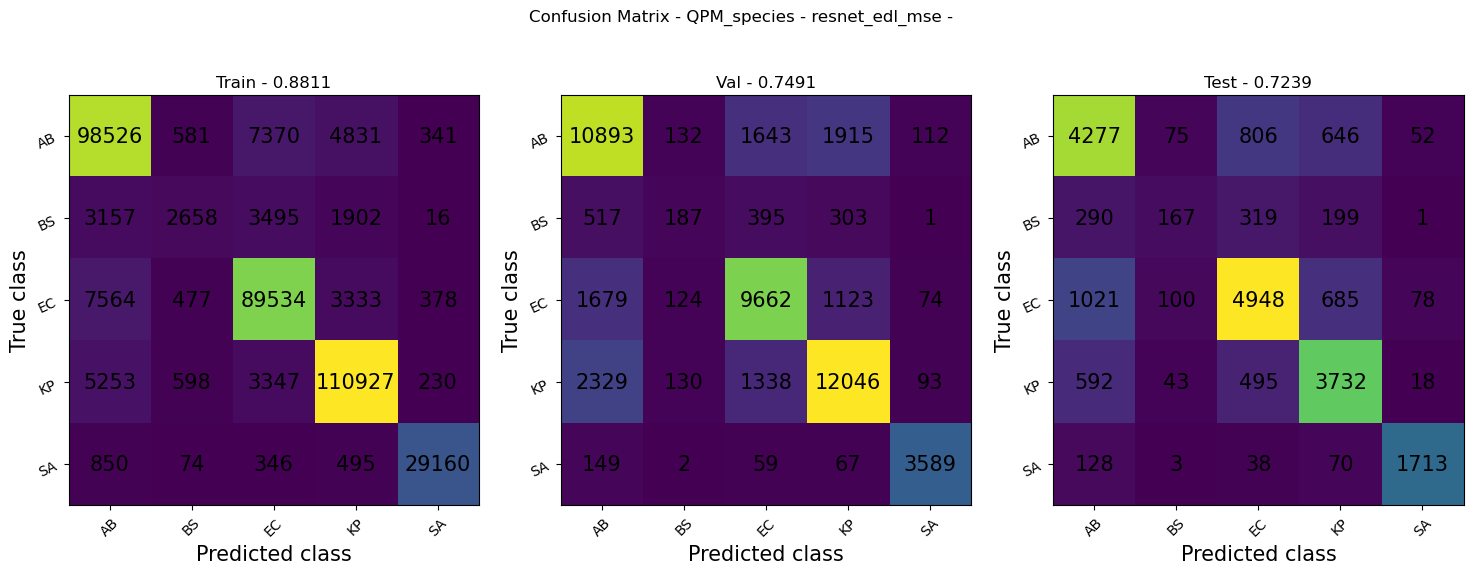

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


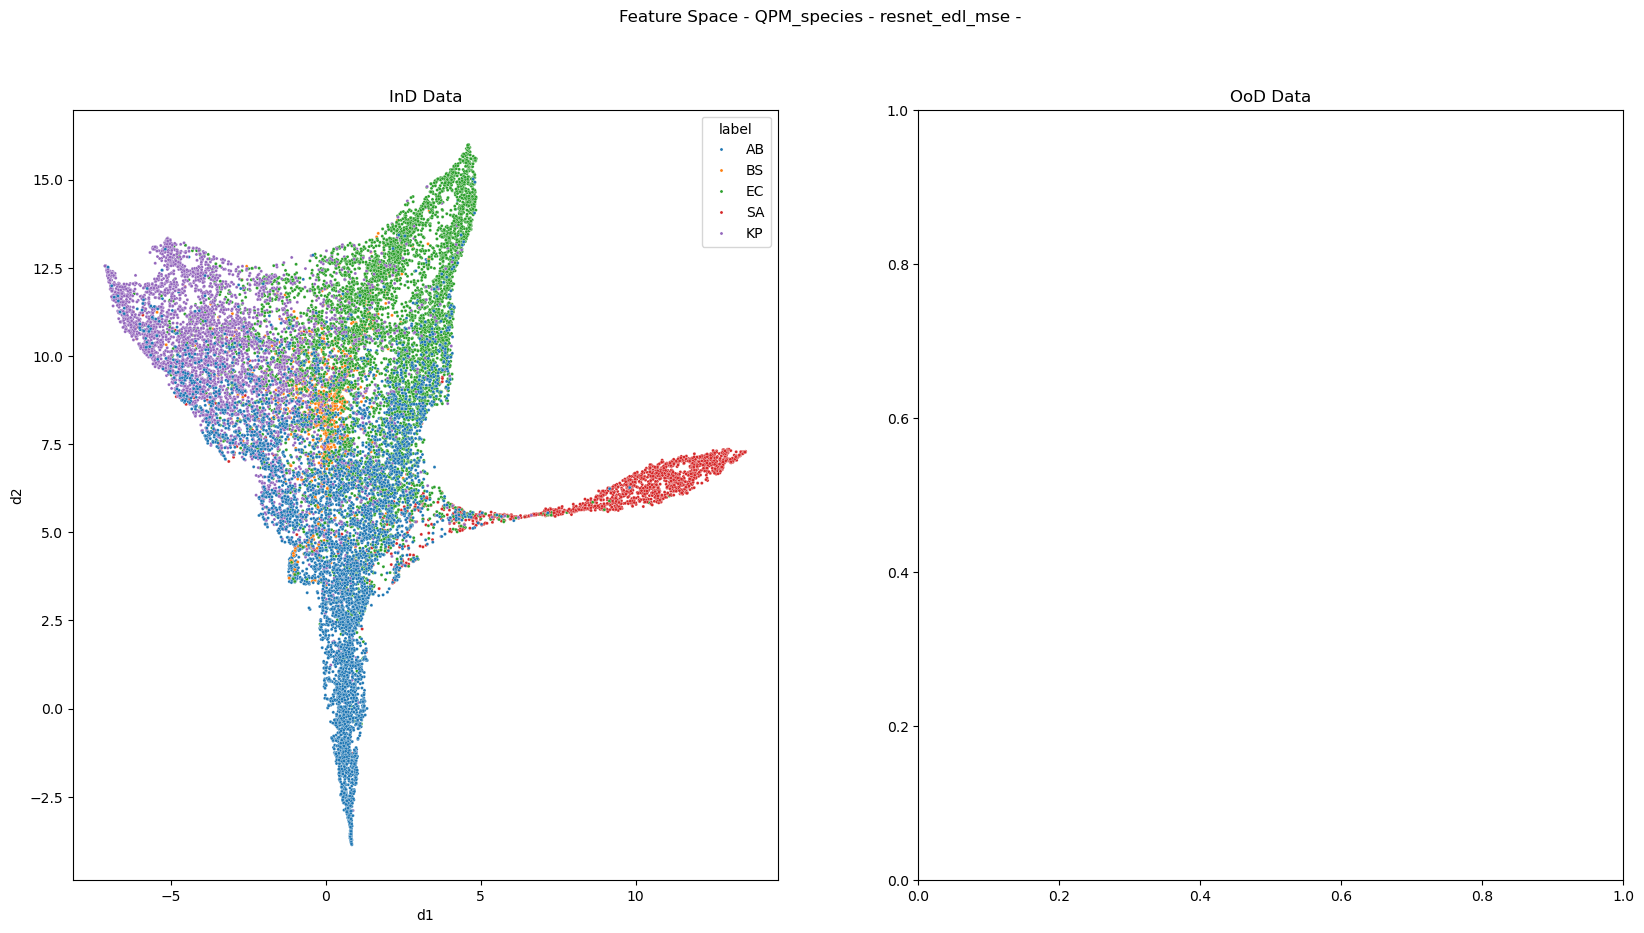

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

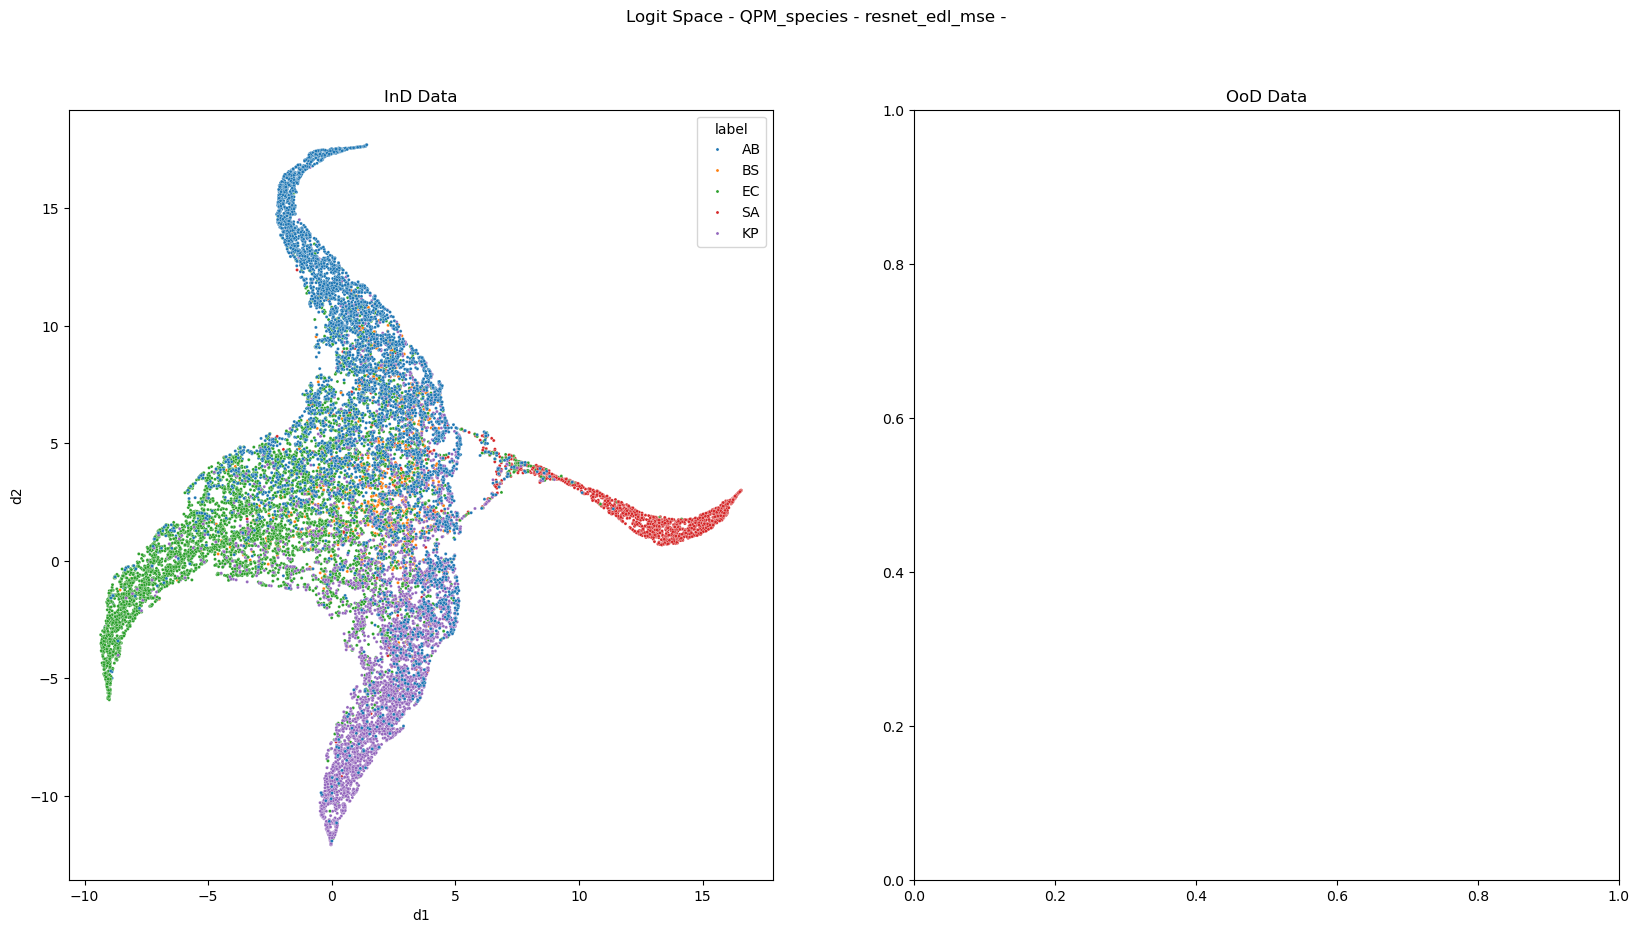

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

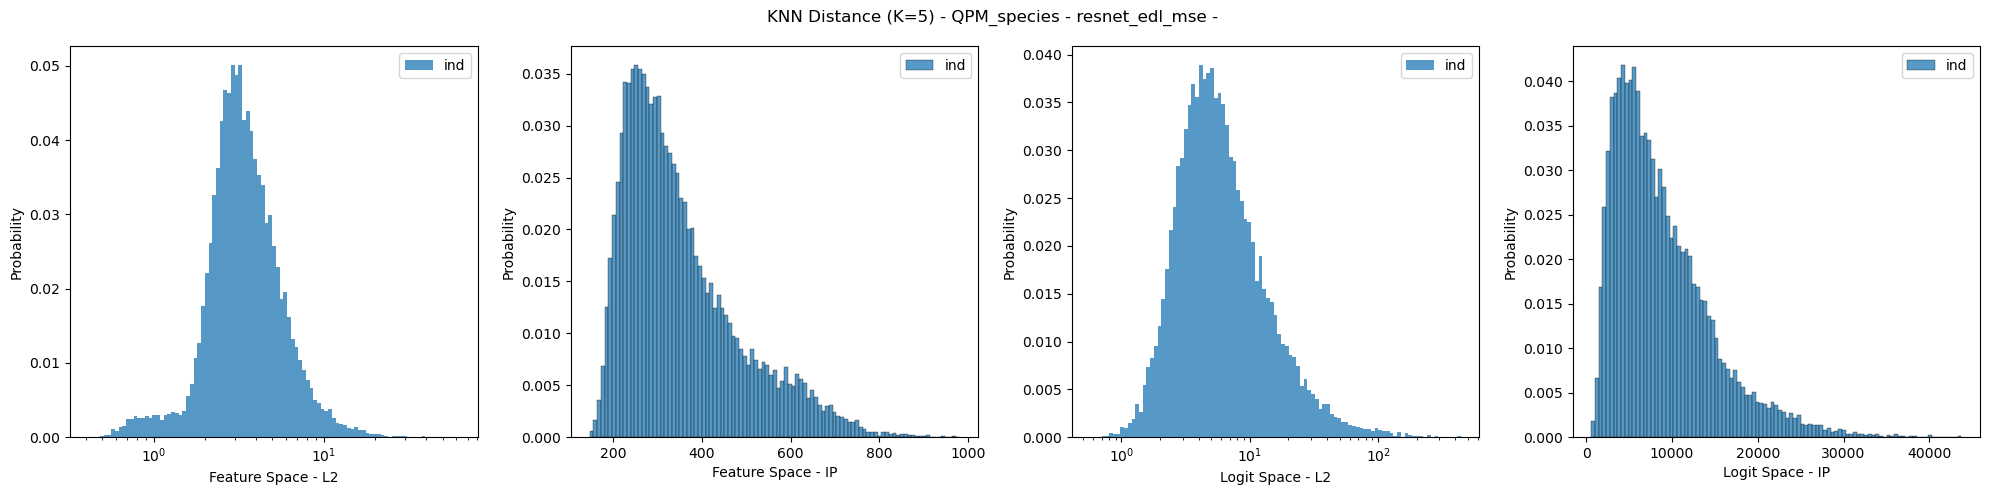

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

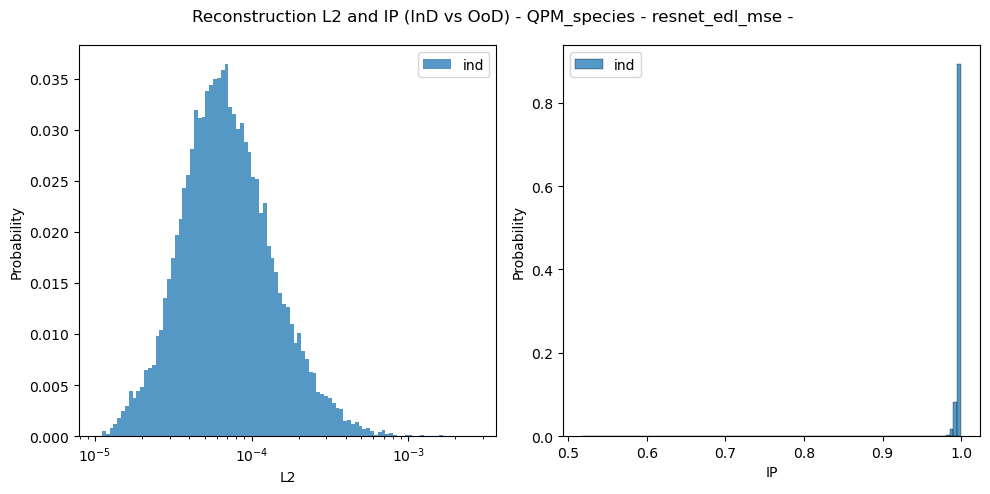

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

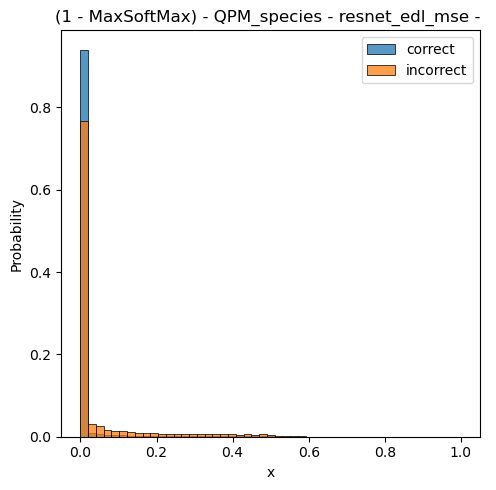

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

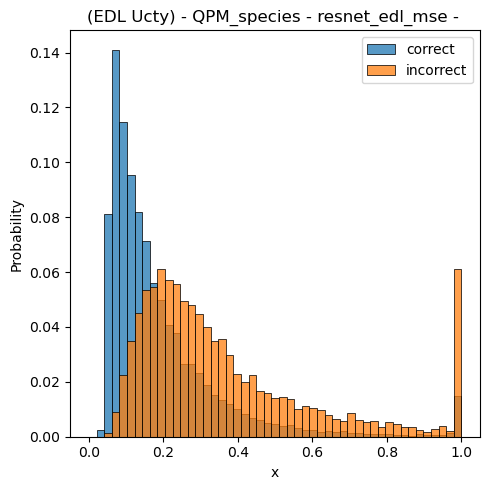

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [19]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)